In [1]:
!pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install -q transformers datasets accelerate wandb sacrebleu sentencepiece
!pip install -q peft bitsandbytes pyyaml tqdm sacremoses

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 42.4 MB/s eta 0:00:00


In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
from collections import defaultdict
import random
import os
import sys
from tqdm.auto import tqdm
from dataclasses import dataclass, field
from typing import Dict, Any, Optional, List
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Базовый эксперимент

## Подготовка данных

In [123]:
class TranslationDataset(Dataset):
    """Датасет для перевода"""
    def __init__(self, data, split="train"):
        """
        Args:
            data: список словарей с ключами:
                  - 'original': исходный текст
                  - 'russian_translation': русский перевод
                  - 'lang': язык оригинала
            split: "train", "val", "test"
        """
        self.data = data
        self.split = split

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        return {
            'input': item['original'],
            'output': item['russian_translation'],
            'language': item['lang']
        }

def load_your_dataset():
    try:
        print("Загрузка датасета с Hugging Face...")
        dataset = load_dataset("katykool/samoyed.ic")

        if 'train' in dataset:
            data = dataset['train']
        else:
            data = dataset

        print(f"Загружено {len(data)} примеров из датасета")

        processed_data = []
        skipped = 0

        for i, item in enumerate(data):
            try:
                original = item.get('original', '')
                russian = item.get('russian_translation', '')
                lang = item.get('lang', '')

                if (original and russian and lang and
                    isinstance(original, str) and
                    isinstance(russian, str) and
                    isinstance(lang, str) and
                    len(original.strip()) > 0 and
                    len(russian.strip()) > 0):

                    processed_data.append({
                        'original': original.strip(),
                        'russian_translation': russian.strip(),
                        'lang': lang.strip().lower()
                    })
                else:
                    skipped += 1

            except Exception as e:
                skipped += 1


        print(f"Обработано {len(processed_data)} примеров, пропущено {skipped}")

        if len(processed_data) == 0:
            print("Нет валидных данных")

        return processed_data

    except Exception as e:
        print(f"Ошибка загрузки датасета: {e}")


def create_language_clients(config, tokenizer):
    """
    Создает клиентов по языкам
    """
    all_data = load_your_dataset()

    if not all_data:
        print("Нет данных!")

    # группируем данные по языкам
    data_by_language = defaultdict(list)
    for item in all_data:
        lang = item.get('lang', 'unknown')
        data_by_language[lang].append(item)

    print(f"\nРаспределение данных по языкам:")
    for lang, items in data_by_language.items():
        print(f"  - {lang.upper()}: {len(items)} примеров")

    # создаем DataLoader для каждого клиента
    train_loaders = {}
    val_loaders = {}
    test_loaders = {}

    # ограничиваем количество клиентов, если их больше чем config.npeers
    languages = list(data_by_language.keys())
    if len(languages) > config.npeers:
        languages = languages[:config.npeers]

    for i, lang in enumerate(languages):
        if i >= config.npeers:
            break

        lang_data = data_by_language[lang]
        random.shuffle(lang_data)  # перемешиваем данные

        # разделяем на train/val/test (70/15/15)
        n_total = len(lang_data)
        n_train = int(n_total * 0.7)
        n_val = int(n_total * 0.15)

        train_data = lang_data[:n_train]
        val_data = lang_data[n_train:n_train + n_val]
        test_data = lang_data[n_train + n_val:]

        # пример данных
        # if len(train_data) > 0:
        #     print(f"   Пример: '{train_data[0]['original'][:50]}...' → '{train_data[0]['russian_translation'][:50]}...'")

        # создаем датасеты
        train_dataset = TranslationDataset(train_data, split="train")
        val_dataset = TranslationDataset(val_data, split="val")
        test_dataset = TranslationDataset(test_data, split="test")

        # создаем DataLoaderы
        train_loader = DataLoader(
            train_dataset,
            batch_size=config.batch_size,
            shuffle=True,
            collate_fn=lambda x: x,
            num_workers=0
        )

        val_loader = DataLoader(
            val_dataset,
            batch_size=config.batch_size,
            shuffle=False,
            collate_fn=lambda x: x,
            num_workers=0
        )

        test_loader = DataLoader(
            test_dataset,
            batch_size=config.batch_size,
            shuffle=False,
            collate_fn=lambda x: x,
            num_workers=0
        )

        train_loaders[i] = train_loader
        val_loaders[i] = val_loader
        test_loaders[i] = test_loader

    # общий валидационный загрузчик из всех языков
    all_val_data = []
    for lang_data in data_by_language.values():
        all_val_data.extend(lang_data[:min(5, len(lang_data))])  # по 5 примеров из каждого языка

    random.shuffle(all_val_data)
    combined_val_dataset = TranslationDataset(all_val_data, split="val")
    combined_val_loader = DataLoader(
        combined_val_dataset,
        batch_size=config.batch_size,
        shuffle=False,
        collate_fn=lambda x: x,
        num_workers=0
    )

    return train_loaders, combined_val_loader, test_loaders

## Конфигурация

In [124]:
project_root = "/content/meritopt"
os.makedirs(project_root, exist_ok=True)

sys.path.append(project_root)

In [125]:
@dataclass
class Config:
    # основные параметры
    seed: int = 42
    epochs: int = 3
    max_steps: int = 500
    batch_size: int = 2
    lr: float = 3e-5

    # модель (не та, что в оригинальной статье -- но зато помещается в Колаб)
    model_type: str = "MarianMT"
    model_checkpoint: str = "Helsinki-NLP/opus-mt-en-ru"

    # данные
    max_seq_len: int = 32

    # federate learning
    fl: bool = True
    npeers: int = 3  # количество клиентов = языков
    mdlr_: float = 0.1
    mdniters_: int = 2
    fl_beta_1: float = 0.9

    # сохранение
    save_every: int = 100
    save_strategy: str = "steps"
    saving_path: str = "/content/drive/MyDrive/meritopt_checkpoints"

    device: str = field(default_factory=lambda: "cuda" if torch.cuda.is_available() else "cpu")

    def __post_init__(self):
        import os
        os.makedirs(self.saving_path, exist_ok=True)

## Оптимизатор **Merit**

In [126]:
class MeritFedAdamFixed(torch.optim.Optimizer):
    def __init__(self, params, config):
        defaults = dict(lr=config.lr, betas=(0.9, 0.98), eps=1e-9)
        super().__init__(params, defaults)

        self.config = config
        self.device = config.device
        self.npeers = config.npeers
        self.weights = torch.ones(config.npeers, device=self.device) / config.npeers
        self.grads_received = 0
        self.step_count = 0

        # временное хранилище для градиентов
        self.client_gradients = [None] * config.npeers

        # инициализация состояний
        for group in self.param_groups:
            for p in group['params']:
                state = self.state[p]
                state['grads'] = [torch.zeros_like(p, device=self.device) for _ in range(config.npeers)]
                state['m'] = torch.zeros_like(p, device=self.device)
                state['v'] = torch.zeros_like(p, device=self.device)

    def save_client_gradients(self, peer_id, gradients):
        """Сохраняем градиенты клиента для последующей регистрации"""
        self.client_gradients[peer_id] = gradients

    def register_all_gradients(self):
        """Регистрируем все сохраненные градиенты"""
        print(f"\n[register_all_gradients] Step {self.step_count + 1}")

        for peer_id in range(self.npeers):
            gradients = self.client_gradients[peer_id]

            if gradients is None:
                # нулевые градиенты
                for group in self.param_groups:
                    for p in group['params']:
                        self.state[p]['grads'][peer_id].zero_()
                print(f"  Client {peer_id}: zero gradients")
                self.grads_received += 1
                continue

            # копируем сохраненные градиенты
            grad_idx = 0
            total_norm = 0
            param_count = 0

            for group in self.param_groups:
                for p in group['params']:
                    if grad_idx < len(gradients) and gradients[grad_idx] is not None:
                        grad = gradients[grad_idx]
                        self.state[p]['grads'][peer_id].copy_(grad)

                        # Вычисляем норму
                        grad_norm = torch.norm(grad, p=2).item()
                        total_norm += grad_norm
                        param_count += 1

                    grad_idx += 1

            if param_count > 0:
                print(f"  Client {peer_id}: total grad norm = {total_norm:.6f} ({param_count} params)")
            else:
                print(f"  Client {peer_id}: NO gradients saved")

            self.grads_received += 1

        # Очищаем временное хранилище
        self.client_gradients = [None] * self.npeers

    def step(self, closure=None):
        """Шаг оптимизации"""
        if self.grads_received < self.npeers:
            print(f"WARNING: Not enough gradients ({self.grads_received}/{self.npeers})")
            return

        self.step_count += 1
        print(f"\n=== Optimizer Step {self.step_count} ===")

        for group in self.param_groups:
            for p in group['params']:
                state = self.state[p]

                # агрегируем градиенты с весами
                agg_grad = torch.zeros_like(p, device=self.device)
                for i in range(self.npeers):
                    agg_grad += state['grads'][i] * self.weights[i]

                # adam update
                beta1, beta2 = group['betas']
                m, v = state['m'], state['v']

                m = beta1 * m + (1 - beta1) * agg_grad
                v = beta2 * v + (1 - beta2) * agg_grad.pow(2)

                m_hat = m / (1 - beta1 ** self.step_count)
                v_hat = v / (1 - beta2 ** self.step_count)

                update = -group['lr'] * m_hat / (v_hat.sqrt() + group['eps'])
                p.data.add_(update)

                # сохраняем моменты
                state['m'].copy_(m)
                state['v'].copy_(v)

        # сбрасываем счетчик
        self.grads_received = 0

        # обновляем веса клиентов
        self._update_client_weights()

    def _update_client_weights(self):
        """Обновление весов клиентов на основе нормы градиентов"""
        print(f"\n=== Updating Client Weights (Step {self.step_count}) ===")

        # собираем нормы градиентов
        grad_norms = torch.zeros(self.npeers, device=self.device)

        for group in self.param_groups:
            for p_idx, p in enumerate(group['params'][:3]):  # первые 3 параметра
                state = self.state[p]
                for i in range(self.npeers):
                    grad_norm = torch.norm(state['grads'][i], p=2).item()
                    grad_norms[i] += grad_norm

        print(f"Gradient norms: {grad_norms.tolist()}")

        # если все нули - оставляем текущие веса
        if torch.all(grad_norms == 0):
            print("WARNING: All gradients are zero! Keeping previous weights.")
            print(f"Current weights: {self.weights.tolist()}")
            return

        # 3. обновляем веса (меньшая норма = больший вес)
        epsilon = 1e-8
        inverse_norms = 1.0 / (grad_norms + epsilon)
        target_weights = inverse_norms / inverse_norms.sum()

        # 4. плавное обновление
        alpha = 0.3
        self.weights = alpha * target_weights + (1 - alpha) * self.weights
        self.weights = self.weights / self.weights.sum()

        print(f"Target weights: {target_weights.tolist()}")
        print(f"Updated weights: {self.weights.tolist()}")
        print("="*50)

    def zero_grad(self):
        """очищаем градиенты"""
        super().zero_grad()
        # очищаем сохраненные градиенты клиентов
        for group in self.param_groups:
            for p in group['params']:
                state = self.state[p]
                for i in range(self.npeers):
                    state['grads'][i].zero_()

## Технические штуки

### Логгер

In [127]:
class SimpleLogger:
    def __init__(self):
        self.step = 0
        self.mode = "train"
        self.metrics_history = []

    def set_step(self, step, mode="train"):
        self.step = step
        self.mode = mode

    def get_step(self):
        return self.step

    def add_scalar(self, name, value):
        # print(f"Step {self.step} ({self.mode}): {name} = {value:.4f}")
        self.metrics_history.append({
            'step': self.step,
            'mode': self.mode,
            'name': name,
            'value': value
        })

    def add_dict(self, metrics_dict):
        for k, v in metrics_dict.items():
            self.add_scalar(k, v)

### Перемещение тензоров

In [128]:
def move_to_device(data, device):
    """Перемещает все тензоры в словаре на указанное устройство"""
    if isinstance(data, dict):
        return {k: move_to_device(v, device) for k, v in data.items()}
    elif isinstance(data, torch.Tensor):
        return data.to(device)
    elif isinstance(data, list):
        return [move_to_device(item, device) for item in data]
    else:
        return data

## Federate learning

### Training

In [129]:
def train_epoch_fl_simple_fixed(model, tokenizer, optimizer, train_loaders, val_loader, logger, config, epoch, val_every=50):
    model.train()

    loader_iters = {i: iter(loader) for i, loader in train_loaders.items()}
    n_batches = min(len(loader) for loader in train_loaders.values())

    pbar = tqdm(range(n_batches), desc=f"FL Epoch {epoch+1}")
    total_loss = 0

    for batch_idx in pbar:
        current_step = logger.get_step() + 1
        logger.set_step(current_step, "train")

        batch_loss = 0

        # сбрасываем временные градиенты
        optimizer.client_gradients = [None] * config.npeers

        # обрабатываем каждого клиента
        for client_id in range(config.npeers):
            print(f"\n[Processing] Client {client_id}, batch {batch_idx}")

            try:
                batch = next(loader_iters[client_id])
            except StopIteration:
                loader_iters[client_id] = iter(train_loaders[client_id])
                batch = next(loader_iters[client_id])

            valid_items = []
            for item in batch:
                input_text = item.get('input', '')
                output_text = item.get('output', '')
                if input_text and output_text:
                    valid_items.append(item)

            if not valid_items:
                print(f"  No valid items for client {client_id}")
                optimizer.save_client_gradients(client_id, None)
                continue

            inputs = [item['input'] for item in valid_items]
            outputs = [item['output'] for item in valid_items]

            try:
                model_inputs = tokenizer(
                    inputs,
                    padding=True,
                    truncation=True,
                    max_length=config.max_seq_len,
                    return_tensors="pt"
                ).to(config.device)

                labels = tokenizer(
                    outputs,
                    padding=True,
                    truncation=True,
                    max_length=config.max_seq_len,
                    return_tensors="pt"
                ).to(config.device)

                # forward pass
                outputs = model(
                    input_ids=model_inputs['input_ids'],
                    attention_mask=model_inputs['attention_mask'],
                    labels=labels['input_ids']
                )

                loss = outputs.loss
                batch_loss += loss.item()
                print(f"  Loss for client {client_id}: {loss.item():.4f}")

                # обнуляем старые градиенты
                model.zero_grad()

                # backward pass
                loss.backward()

                # градиенты текущего клиента
                client_gradients = []
                for group in optimizer.param_groups:
                    for p in group['params']:
                        if p.grad is not None:
                            # Клонируем и детачим
                            client_gradients.append(p.grad.clone().detach())
                        else:
                            client_gradients.append(None)

                print(f"  Collected {len([g for g in client_gradients if g is not None])} gradients")

                # градиенты
                optimizer.save_client_gradients(client_id, client_gradients)

            except Exception as e:
                print(f"Error processing client {client_id}: {e}")
                optimizer.save_client_gradients(client_id, None)
                continue

        # после обработки всех клиентов регистрируем градиенты
        optimizer.register_all_gradients()

        # шаг оптимизации
        if batch_loss > 0:
            optimizer.step()
            optimizer.zero_grad()

            avg_loss = batch_loss / config.npeers
            total_loss += avg_loss
            logger.add_scalar("loss", avg_loss)

            # логируем веса клиентов
            for i, w in enumerate(optimizer.weights):
                logger.add_scalar(f"weight_client_{i}", w.item())

            pbar.set_postfix({"loss": avg_loss})

            # валидация
            if current_step % val_every == 0:
                print(f"\n[Validation] Step {current_step}")
                model.eval()

                val_loss_total = 0
                val_batches = 0

                with torch.no_grad():
                    val_iter = iter(val_loader)
                    for _ in range(min(5, len(val_loader))):
                        try:
                            val_batch = next(val_iter)
                        except StopIteration:
                            break

                        val_inputs = [item.get('input', '') for item in val_batch if 'input' in item]
                        val_outputs = [item.get('output', '') for item in val_batch if 'output' in item]

                        if val_inputs and val_outputs:
                            val_model_inputs = tokenizer(
                                val_inputs,
                                padding=True,
                                truncation=True,
                                max_length=config.max_seq_len,
                                return_tensors="pt"
                            ).to(config.device)

                            val_labels = tokenizer(
                                val_outputs,
                                padding=True,
                                truncation=True,
                                max_length=config.max_seq_len,
                                return_tensors="pt"
                            ).to(config.device)

                            val_outputs = model(
                                input_ids=val_model_inputs['input_ids'],
                                attention_mask=val_model_inputs['attention_mask'],
                                labels=val_labels['input_ids']
                            )

                            val_loss_total += val_outputs.loss.item()
                            val_batches += 1

                if val_batches > 0:
                    avg_val_loss = val_loss_total / val_batches
                    logger.set_step(current_step, "val")
                    logger.add_scalar("val_loss", avg_val_loss)
                    logger.set_step(current_step, "train")
                    print(f"  Val Loss = {avg_val_loss:.4f} ({val_batches} batches)")

                model.train()

            if current_step % config.save_every == 0:
                save_model_simple(model, tokenizer, config, iteration=current_step)

            if current_step >= config.max_steps:
                print(f"\nReached max steps ({config.max_steps}), stopping...")
                break

    return total_loss / n_batches if n_batches > 0 else 0

### Validation

In [130]:
def validate_simple(model, tokenizer, val_loader, logger, config, max_batches=None):
    model.eval()
    total_loss = 0
    total_batches = 0

    val_iter = iter(val_loader)

    if max_batches is None:
        max_batches = min(20, len(val_loader))

    with torch.no_grad():
        for batch_idx in range(max_batches):
            try:
                batch = next(val_iter)
            except StopIteration:
                val_iter = iter(val_loader)
                batch = next(val_iter)

            valid_items = []
            for item in batch:
                input_text = item.get('input', '')
                output_text = item.get('output', '')
                if input_text and output_text:
                    valid_items.append(item)

            if not valid_items:
                continue

            inputs = [item['input'] for item in valid_items]
            outputs = [item['output'] for item in valid_items]

            try:
                model_inputs = tokenizer(
                    inputs,
                    padding=True,
                    truncation=True,
                    max_length=config.max_seq_len,
                    return_tensors="pt"
                ).to(config.device)

                labels = tokenizer(
                    outputs,
                    padding=True,
                    truncation=True,
                    max_length=config.max_seq_len,
                    return_tensors="pt"
                ).to(config.device)

                outputs = model(
                    input_ids=model_inputs['input_ids'],
                    attention_mask=model_inputs['attention_mask'],
                    labels=labels['input_ids']
                )

                loss = outputs.loss
                total_loss += loss.item()
                total_batches += 1

            except Exception as e:
                print(f"Validation error in batch {batch_idx}: {e}")
                continue

    # возвращаем модель в исходный режим
    avg_loss = total_loss / total_batches if total_batches > 0 else 0
    return avg_loss, total_batches

### Saving

In [131]:
def save_model_simple(model, tokenizer, config, epoch=None, iteration=None):

    if epoch is not None:
        save_path = f"{config.saving_path}/epoch_{epoch}"
    elif iteration is not None:
        save_path = f"{config.saving_path}/step_{iteration}"
    else:
        save_path = f"{config.saving_path}/final"

    os.makedirs(save_path, exist_ok=True)

    # сохраняем модель
    model.save_pretrained(save_path)
    tokenizer.save_pretrained(save_path)

    # сохраняем веса если есть
    if hasattr(config, 'optimizer') and hasattr(config.optimizer, 'weights'):
        torch.save(
            config.optimizer.weights.cpu(),
            f"{save_path}/fl_weights.pt"
        )

    print(f"Модель сохранена в {save_path}")

### Тестирование и визуализация

In [64]:
import numpy as np

In [137]:
def test_model(model, tokenizer, config, test_loaders=None):

    model.eval()

    if test_loaders is None:
        print('TestLoaders пустые!')

    else:
        # тестируем на тестовых данных каждого клиента
        total_samples = 0
        total_correct = 0

        for client_id, test_loader in test_loaders.items():
            print(f"\n👥 Клиент {client_id}:")
            print("-" * 30)

            client_samples = 0
            client_correct = 0

            # несколько примеров
            max_test_samples = min(2, len(test_loader.dataset))
            test_dataset = test_loader.dataset

            for i in range(max_test_samples):
                try:
                    sample = test_dataset[i]
                    original_text = sample['input']
                    reference_translation = sample['output']
                    lang = sample['language']

                    # пропускаем если текст пустой
                    if not original_text or not reference_translation:
                        continue

                    inputs = tokenizer(
                        original_text,
                        return_tensors="pt",
                        padding=True,
                        truncation=True,
                        max_length=config.max_seq_len
                    ).to(config.device)

                    with torch.no_grad():
                        outputs = model.generate(**inputs, max_length=config.max_seq_len)

                    predicted_translation = tokenizer.decode(outputs[0], skip_special_tokens=True)

                    print(f"Язык: {lang}")
                    print(f"Оригинал: {original_text[:80]}...")
                    print(f"Эталон: {reference_translation[:80]}...")
                    print(f"Модель: {predicted_translation[:80]}...")
                    print("-" * 40)

                    client_samples += 1
                    total_samples += 1

                    # простая метрика сходства (хорошо бы заменить на BLEU)
                    ref_words = set(reference_translation.lower().split()[:10])
                    pred_words = set(predicted_translation.lower().split()[:10])
                    overlap = len(ref_words.intersection(pred_words)) / max(len(ref_words), 1)

                    if overlap > 0.3:  # порог для "правильного" перевода
                        client_correct += 1
                        total_correct += 1

                except Exception as e:
                    print(f"Ошибка при тестировании примера {i}: {e}")
                    continue

            if client_samples > 0:
                accuracy = client_correct / client_samples
                print(f"Клиент {client_id}: точность = {accuracy:.2%} ({client_correct}/{client_samples})")

        if total_samples > 0:
            overall_accuracy = total_correct / total_samples
            print(f"\nОБЩАЯ ТОЧНОСТЬ: {overall_accuracy:.2%} ({total_correct}/{total_samples})")
        else:
            print("Нет тестовых данных для оценки")


def visualize_results(logger, smooth_window=10):
    try:
        import matplotlib.pyplot as plt
        import numpy as np

        def smooth_curve_centered(data, window_size=5):
            """Центрированное скользящее среднее"""
            if len(data) < window_size or window_size < 2:
                return data.copy()

            smoothed = np.zeros_like(data, dtype=float)
            half = window_size // 2

            for i in range(len(data)):
                start = max(0, i - half)
                end = min(len(data), i + half + 1)
                smoothed[i] = np.mean(data[start:end])

            return smoothed

        # собираем данные
        train_losses = []
        val_losses = []
        client_weights = {i: [] for i in range(3)}

        # шаги для каждой метрики
        train_steps = []
        val_steps = []
        weight_steps = {i: [] for i in range(3)}

        for metric in logger.metrics_history:
            if metric['name'] == 'loss' and metric['mode'] == 'train':
                train_losses.append(metric['value'])
                train_steps.append(metric['step'])
            elif metric['name'] == 'val_loss':
                val_losses.append(metric['value'])
                val_steps.append(metric['step'])
            elif 'weight_client' in metric['name']:
                try:
                    client_id = int(metric['name'].split('_')[-1])
                    client_weights[client_id].append(metric['value'])
                    weight_steps[client_id].append(metric['step'])
                except:
                    pass

        # график loss
        plt.figure(figsize=(16, 8))

        if train_losses:
            plt.subplot(2, 2, 1)

            # plt.scatter(train_steps, train_losses, alpha=0.3, s=15, color='blue',
            #            label=f'Raw Train Loss ({len(train_losses)} points)')

            # сглаженные данные train
            if len(train_losses) >= smooth_window:
                smoothed_train = smooth_curve_centered(train_losses, smooth_window)
                plt.plot(train_steps, smoothed_train, 'b-', linewidth=3,
                        label=f'Train Loss (smoothed, w={smooth_window})')
            else:
                plt.plot(train_steps, train_losses, 'b-', linewidth=2, label='Train Loss')

            if val_losses and len(val_losses) > 0:
                # plt.scatter(val_steps, val_losses, alpha=0.7, s=80, color='red',
                #            marker='s', label=f'Raw Val Loss ({len(val_losses)} points)')

                if len(val_losses) >= max(3, smooth_window//2):
                    smoothed_val = smooth_curve_centered(val_losses, min(smooth_window, len(val_losses)))
                    plt.plot(val_steps, smoothed_val, 'r--', linewidth=3,
                            label=f'Val Loss (smoothed)', markersize=8)
                else:
                    # если мало точек, просто соединяем линией
                    plt.plot(val_steps, val_losses, 'r--', linewidth=2,
                            label='Val Loss', markersize=8)

            plt.xlabel('Step')
            plt.ylabel('Loss')
            plt.title('Training Progress (Train vs Validation)')
            plt.legend(loc='best')
            plt.grid(True, alpha=0.3)

            if train_losses:
                y_max = max(max(train_losses), max(val_losses) if val_losses else 0) * 1.1
                y_min = min(min(train_losses), min(val_losses) if val_losses else 0) * 0.9
                plt.ylim(y_min, y_max)

        # график весов клиентов
        plt.subplot(2, 2, 2)
        has_weights = False

        colors = ['blue', 'green', 'red']
        labels = ['Client 0 (ENF)', 'Client 1 (NGA)', 'Client 2 (NEN)']

        for client_id in range(3):
            weights = client_weights.get(client_id, [])
            steps = weight_steps.get(client_id, [])

            if weights and len(weights) > 0:
                has_weights = True

                # оригинальные данные
                # plt.scatter(steps, weights, alpha=0.3, s=20, color=colors[client_id])

                # сглаженные данные
                if len(weights) >= smooth_window:
                    smoothed_weights = smooth_curve_centered(weights, smooth_window)
                    plt.plot(steps, smoothed_weights, color=colors[client_id],
                            linewidth=3, label=labels[client_id])
                else:
                    plt.plot(steps, weights, color=colors[client_id],
                            linewidth=2, label=labels[client_id])

        if has_weights:
            plt.xlabel('Step')
            plt.ylabel('Weight')
            plt.title('Client Weights Evolution')
            plt.legend(loc='best')
            plt.grid(True, alpha=0.3)

            # линия равных весов
            plt.axhline(y=1/3, color='gray', linestyle=':', alpha=0.7,
                       linewidth=2, label='Equal (1/3)')
            plt.legend()

            plt.ylim(-0.05, 1.05)

        # гистограмма средних весов
        plt.subplot(2, 2, 3)

        avg_weights = []
        std_weights = []
        client_labels = []

        for client_id in range(3):
            weights = client_weights.get(client_id, [])
            if weights:
                avg_weights.append(np.mean(weights))
                std_weights.append(np.std(weights) if len(weights) > 1 else 0)
                client_labels.append(f'Client {client_id}')

        if avg_weights:
            x_pos = np.arange(len(avg_weights))
            bars = plt.bar(x_pos, avg_weights, yerr=std_weights,
                          color=colors[:len(avg_weights)], alpha=0.7,
                          capsize=5, error_kw={'elinewidth': 2})

            plt.axhline(y=1/3, color='gray', linestyle='--', alpha=0.5, label='Equal')

            for i, (bar, avg, std) in enumerate(zip(bars, avg_weights, std_weights)):
                height = bar.get_height()
                plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                        f'{avg:.3f} ± {std:.3f}', ha='center', va='bottom', fontsize=9)

            plt.xticks(x_pos, client_labels)
            plt.ylabel('Average Weight')
            plt.title('Average Client Weights with Std Dev')
            plt.legend()

    except Exception as e:
        print(f"Не удалось построить графики: {e}")
        import traceback
        traceback.print_exc()

## Основная функция обучения

In [138]:
def main_simple():
    config = Config()
    config.npeers = 3
    config.epochs = 1
    config.max_steps = 500
    config.batch_size = 2
    config.val_every = 50

    logger = SimpleLogger()

    tokenizer = AutoTokenizer.from_pretrained(config.model_checkpoint)
    model = AutoModelForSeq2SeqLM.from_pretrained(config.model_checkpoint)
    model = model.to(config.device)

    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    train_loaders, val_loader, test_loaders = create_language_clients(config, tokenizer)

    optimizer = MeritFedAdamFixed(model.parameters(), config)

    print(f"\n{'='*60}")
    print(f"Starting FIXED training (max_steps={config.max_steps})")
    print(f"{'='*60}")

    for epoch in range(config.epochs):
        print(f"\nEpoch {epoch+1}/{config.epochs}")

        train_loss = train_epoch_fl_simple_fixed(
            model=model,
            tokenizer=tokenizer,
            optimizer=optimizer,
            train_loaders=train_loaders,
            val_loader=val_loader,
            logger=logger,
            config=config,
            epoch=epoch,
            val_every=config.val_every
        )

        # Финальная валидация
        model.eval()
        val_loss, val_batches = validate_simple(model, tokenizer, val_loader, logger, config)
        model.train()

        print(f"\nEpoch {epoch+1} completed:")
        print(f"   Train Loss = {train_loss:.4f}")
        print(f"   Val Loss = {val_loss:.4f} ({val_batches} batches)")

        save_model_simple(model, tokenizer, config, epoch=epoch+1)

        if logger.get_step() >= config.max_steps:
            break

    # Быстрое тестирование
    print(f"\n{'='*60}")
    print("Quick test:")
    print(f"{'='*60}")

    model.eval()
    for client_id in range(3):
        if client_id in test_loaders:
            loader = test_loaders[client_id]
            dataset = loader.dataset
            if len(dataset) > 0:
                sample = dataset[0]
                inputs = tokenizer(sample['input'], return_tensors="pt").to(config.device)
                with torch.no_grad():
                    outputs = model.generate(**inputs, max_length=50)
                translation = tokenizer.decode(outputs[0], skip_special_tokens=True)
                print(f"Client {client_id}: {sample['input'][:50]}... -> {translation[:50]}...")

    visualize_results(logger)
    return model, tokenizer, logger

# Запуск

Загрузка датасета с Hugging Face...
Загружено 97434 примеров из датасета
Обработано 96608 примеров, пропущено 826

Распределение данных по языкам:
  - ENF: 51777 примеров
  - NGA: 34609 примеров
  - NEN: 10222 примеров

Starting FIXED training (max_steps=500)

Epoch 1/1


FL Epoch 1:   0%|          | 0/3578 [00:00<?, ?it/s]


[Processing] Client 0, batch 0
  Loss for client 0: 6.0191
  Collected 253 gradients

[Processing] Client 1, batch 0
  Loss for client 1: 7.9001
  Collected 253 gradients

[Processing] Client 2, batch 0
  Loss for client 2: 6.6126
  Collected 253 gradients

[register_all_gradients] Step 1
  Client 0: total grad norm = 261.948647 (253 params)
  Client 1: total grad norm = 490.343046 (253 params)
  Client 2: total grad norm = 267.993286 (253 params)

=== Optimizer Step 1 ===

=== Updating Client Weights (Step 1) ===
Gradient norms: [19.52560043334961, 48.04645538330078, 19.035829544067383]
Target weights: [0.4111641049385071, 0.16709299385547638, 0.42174291610717773]
Updated weights: [0.35668256878852844, 0.28346124291419983, 0.3598562180995941]

[Processing] Client 0, batch 1
  Loss for client 0: 5.5284
  Collected 253 gradients

[Processing] Client 1, batch 1
  Loss for client 1: 5.1832
  Collected 253 gradients

[Processing] Client 2, batch 1
  Loss for client 2: 5.2492
  Collected 2

/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:3918: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 512, 'num_beams': 4, 'bad_words_ids': [[62517]]}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


Выходные данные были обрезаны до нескольких последних строк (5000).
  Collected 253 gradients

[Processing] Client 1, batch 301
  Loss for client 1: 1.8004
  Collected 253 gradients

[Processing] Client 2, batch 301
  Loss for client 2: 1.7311
  Collected 253 gradients

[register_all_gradients] Step 302
  Client 0: total grad norm = 71.450495 (253 params)
  Client 1: total grad norm = 81.558299 (253 params)
  Client 2: total grad norm = 79.692411 (253 params)

=== Optimizer Step 302 ===

=== Updating Client Weights (Step 302) ===
Gradient norms: [7.924553394317627, 8.768647193908691, 8.222269058227539]
Target weights: [0.3487323224544525, 0.31516239047050476, 0.33610525727272034]
Updated weights: [0.3343738615512848, 0.3296582102775574, 0.33596792817115784]

[Processing] Client 0, batch 302
  Loss for client 0: 1.1511
  Collected 253 gradients

[Processing] Client 1, batch 302
  Loss for client 1: 1.9491
  Collected 253 gradients

[Processing] Client 2, batch 302
  Loss for client 2: 1

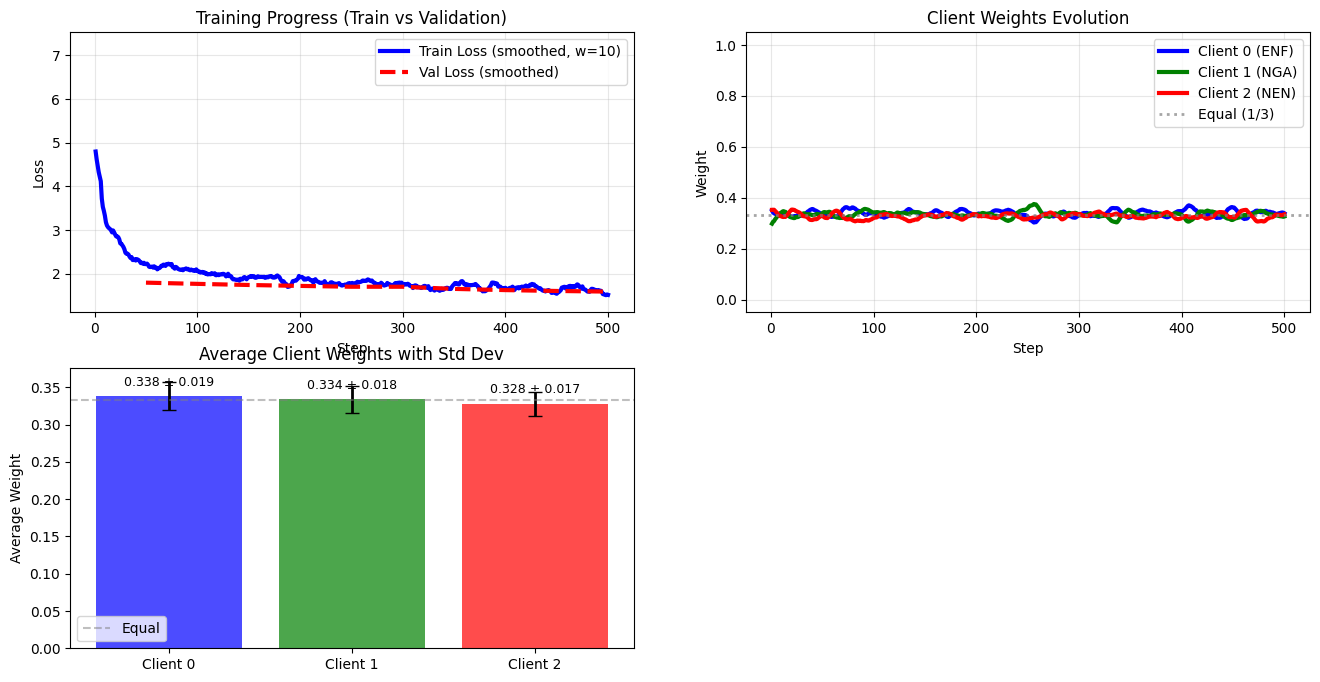

In [139]:
torch.cuda.empty_cache()
try:
    model, tokenizer, logger = main_simple()
except Exception as e:
    print(f"Ошибка: {e}")
    import traceback
    traceback.print_exc()

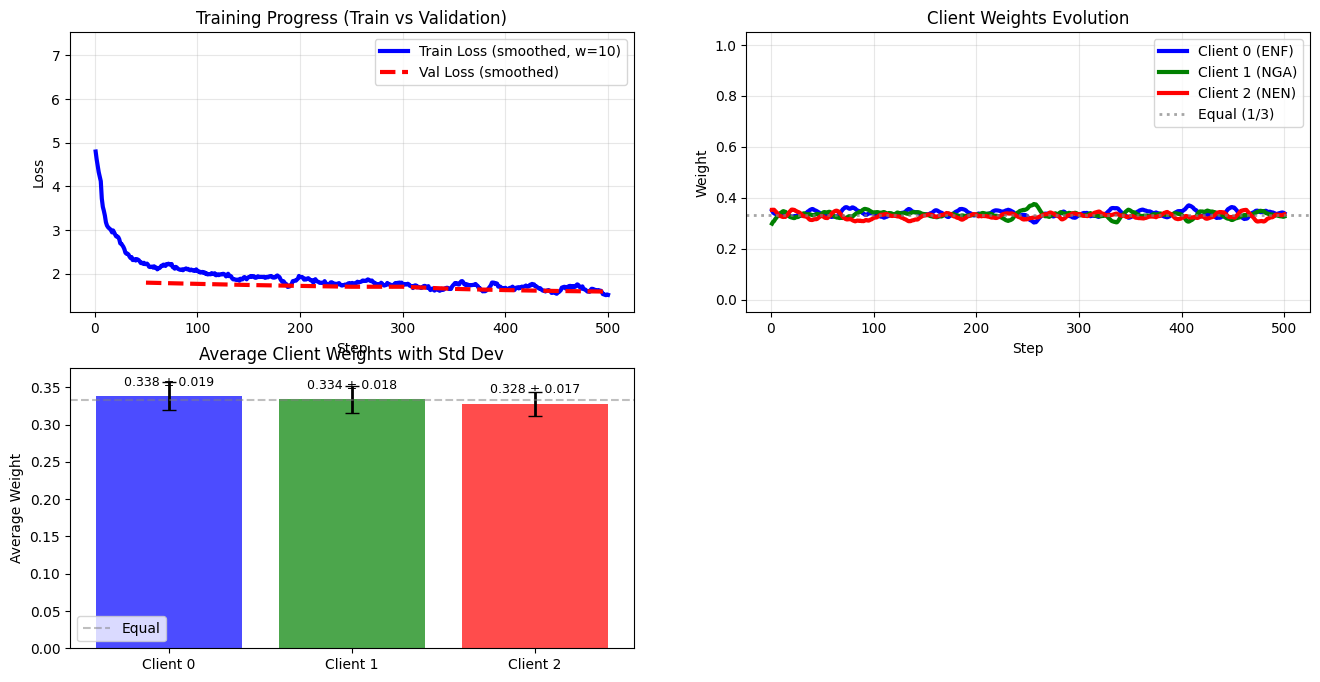

# Уравнивание размера датасетов

In [140]:
def create_language_clients(config, tokenizer):
    """
    Создает клиентов с РАВНЫМ количеством данных для каждого языка
    """
    all_data = load_your_dataset()

    if not all_data:
        print("Нет данных!")
        return {}, None, {}

    # группируем данные по языкам
    data_by_language = defaultdict(list)
    for item in all_data:
        lang = item.get('lang', 'unknown')
        data_by_language[lang].append(item)

    # минимальное количество примеров среди всех языков
    min_samples = min(len(items) for items in data_by_language.values())
    print(f"\nМинимальное количество примеров: {min_samples}")
    print(f"Будем использовать по {min_samples} примеров для каждого языка")

    languages = list(data_by_language.keys())
    if len(languages) > config.npeers:
        languages = languages[:config.npeers]

    # берем одинаковое количество от каждого языка
    balanced_data_by_language = {}
    for i, lang in enumerate(languages):
        if i >= config.npeers:
            break

        lang_data = data_by_language[lang]

        # Берем только min_samples примеров от каждого языка
        if len(lang_data) > min_samples:
            # Случайно выбираем min_samples примеров
            balanced_data = random.sample(lang_data, min_samples)
        else:
            # Если данных меньше min_samples, используем все
            balanced_data = lang_data.copy()
            print(f"  ВНИМАНИЕ: У языка {lang} только {len(lang_data)} примеров")

        balanced_data_by_language[lang] = balanced_data

    # создаем DataLoader для каждого клиента
    train_loaders = {}
    val_loaders = {}
    test_loaders = {}

    for i, lang in enumerate(languages):
        if i >= config.npeers:
            break

        lang_data = balanced_data_by_language[lang]
        random.shuffle(lang_data)  # перемешиваем данные

        # разделяем на train/val/test (70/15/15)
        n_total = len(lang_data)
        n_train = int(n_total * 0.7)
        n_val = int(n_total * 0.15)

        train_data = lang_data[:n_train]
        val_data = lang_data[n_train:n_train + n_val]
        test_data = lang_data[n_train + n_val:]

        print(f"\nКлиент {i} ({lang.upper()}):")
        print(f"  Train: {len(train_data)} примеров")
        print(f"  Val: {len(val_data)} примеров")
        print(f"  Test: {len(test_data)} примеров")

        # создаем датасеты
        train_dataset = TranslationDataset(train_data, split="train")
        val_dataset = TranslationDataset(val_data, split="val")
        test_dataset = TranslationDataset(test_data, split="test")

        # создаем DataLoaderы
        train_loader = DataLoader(
            train_dataset,
            batch_size=config.batch_size,
            shuffle=True,
            collate_fn=lambda x: x,
            num_workers=0
        )

        val_loader = DataLoader(
            val_dataset,
            batch_size=config.batch_size,
            shuffle=False,
            collate_fn=lambda x: x,
            num_workers=0
        )

        test_loader = DataLoader(
            test_dataset,
            batch_size=config.batch_size,
            shuffle=False,
            collate_fn=lambda x: x,
            num_workers=0
        )

        train_loaders[i] = train_loader
        val_loaders[i] = val_loader
        test_loaders[i] = test_loader

    # общий валидационный загрузчик из всех языков (также сбалансированный)
    all_val_data = []
    for lang, lang_data in balanced_data_by_language.items():
        samples_to_take = min(5, len(lang_data))
        all_val_data.extend(lang_data[:samples_to_take])

    random.shuffle(all_val_data)
    combined_val_dataset = TranslationDataset(all_val_data, split="val")
    combined_val_loader = DataLoader(
        combined_val_dataset,
        batch_size=config.batch_size,
        shuffle=False,
        collate_fn=lambda x: x,
        num_workers=0
    )

    print(f"\nОбщий валидационный набор: {len(all_val_data)} примеров")
    print(f"Количество батчей в val_loader: {len(combined_val_loader)}")

    return train_loaders, combined_val_loader, test_loaders

Загрузка датасета с Hugging Face...
Загружено 97434 примеров из датасета
Обработано 96608 примеров, пропущено 826

Минимальное количество примеров: 10222
Будем использовать по 10222 примеров для каждого языка
  ВНИМАНИЕ: У языка nen только 10222 примеров

Клиент 0 (ENF):
  Train: 7155 примеров
  Val: 1533 примеров
  Test: 1534 примеров

Клиент 1 (NGA):
  Train: 7155 примеров
  Val: 1533 примеров
  Test: 1534 примеров

Клиент 2 (NEN):
  Train: 7155 примеров
  Val: 1533 примеров
  Test: 1534 примеров

Общий валидационный набор: 15 примеров
Количество батчей в val_loader: 8

Starting FIXED training (max_steps=500)

Epoch 1/1


FL Epoch 1:   0%|          | 0/3578 [00:00<?, ?it/s]


[Processing] Client 0, batch 0
  Loss for client 0: 6.5508
  Collected 253 gradients

[Processing] Client 1, batch 0
  Loss for client 1: 5.8902
  Collected 253 gradients

[Processing] Client 2, batch 0
  Loss for client 2: 6.2271
  Collected 253 gradients

[register_all_gradients] Step 1
  Client 0: total grad norm = 413.229016 (253 params)
  Client 1: total grad norm = 232.836915 (253 params)
  Client 2: total grad norm = 256.319565 (253 params)

=== Optimizer Step 1 ===

=== Updating Client Weights (Step 1) ===
Gradient norms: [31.8551082611084, 16.13771629333496, 18.907814025878906]
Target weights: [0.21465155482292175, 0.42371225357055664, 0.36163613200187683]
Updated weights: [0.2977288067340851, 0.3604470193386078, 0.34182417392730713]

[Processing] Client 0, batch 1
  Loss for client 0: 5.7095
  Collected 253 gradients

[Processing] Client 1, batch 1
  Loss for client 1: 4.9081
  Collected 253 gradients

[Processing] Client 2, batch 1
  Loss for client 2: 5.0625
  Collected 25

/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:3918: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 512, 'num_beams': 4, 'bad_words_ids': [[62517]]}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


Выходные данные были обрезаны до нескольких последних строк (5000).
  Collected 253 gradients

[Processing] Client 1, batch 301
  Loss for client 1: 1.5789
  Collected 253 gradients

[Processing] Client 2, batch 301
  Loss for client 2: 1.5698
  Collected 253 gradients

[register_all_gradients] Step 302
  Client 0: total grad norm = 91.330610 (253 params)
  Client 1: total grad norm = 74.259309 (253 params)
  Client 2: total grad norm = 65.610002 (253 params)

=== Optimizer Step 302 ===

=== Updating Client Weights (Step 302) ===
Gradient norms: [9.923552513122559, 8.342061996459961, 6.974485874176025]
Target weights: [0.2768229842185974, 0.32930317521095276, 0.39387384057044983]
Updated weights: [0.3193438649177551, 0.3433245122432709, 0.3373316526412964]

[Processing] Client 0, batch 302
  Loss for client 0: 1.7203
  Collected 253 gradients

[Processing] Client 1, batch 302
  Loss for client 1: 1.6709
  Collected 253 gradients

[Processing] Client 2, batch 302
  Loss for client 2: 2.

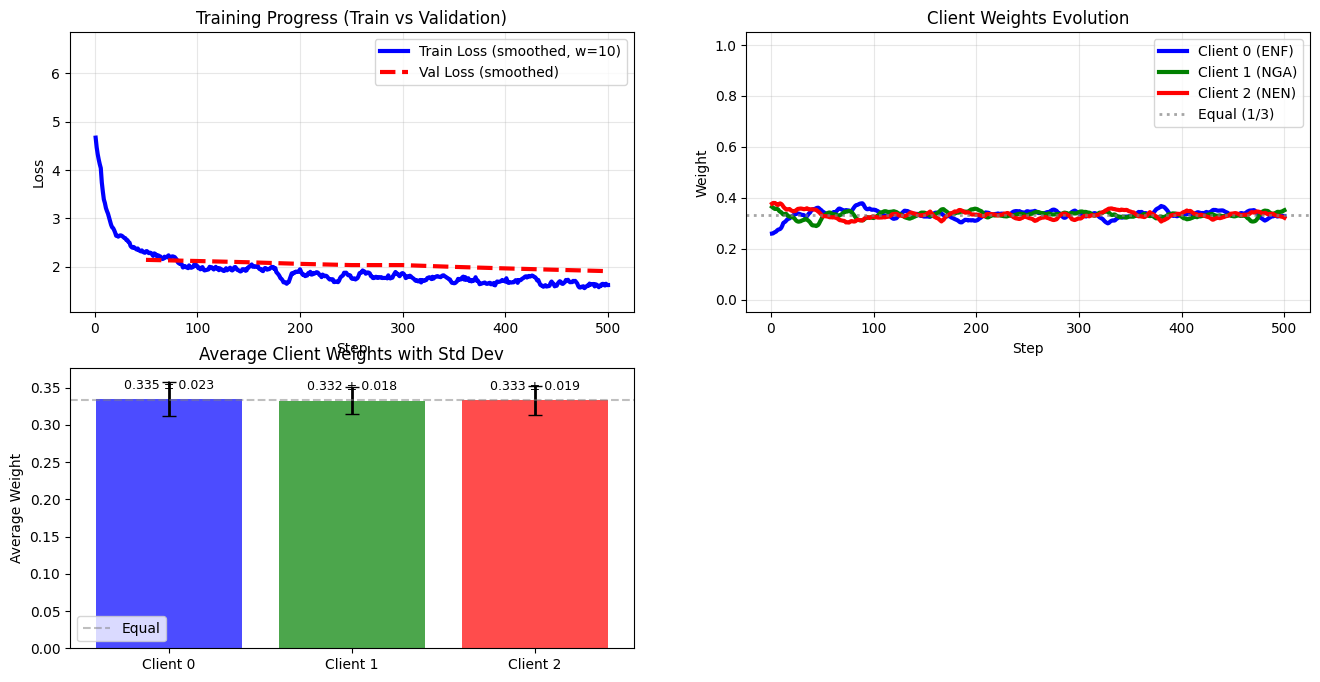

In [141]:
torch.cuda.empty_cache()
try:
    model, tokenizer, logger = main_simple()
except Exception as e:
    print(f"Ошибка: {e}")
    import traceback
    traceback.print_exc()

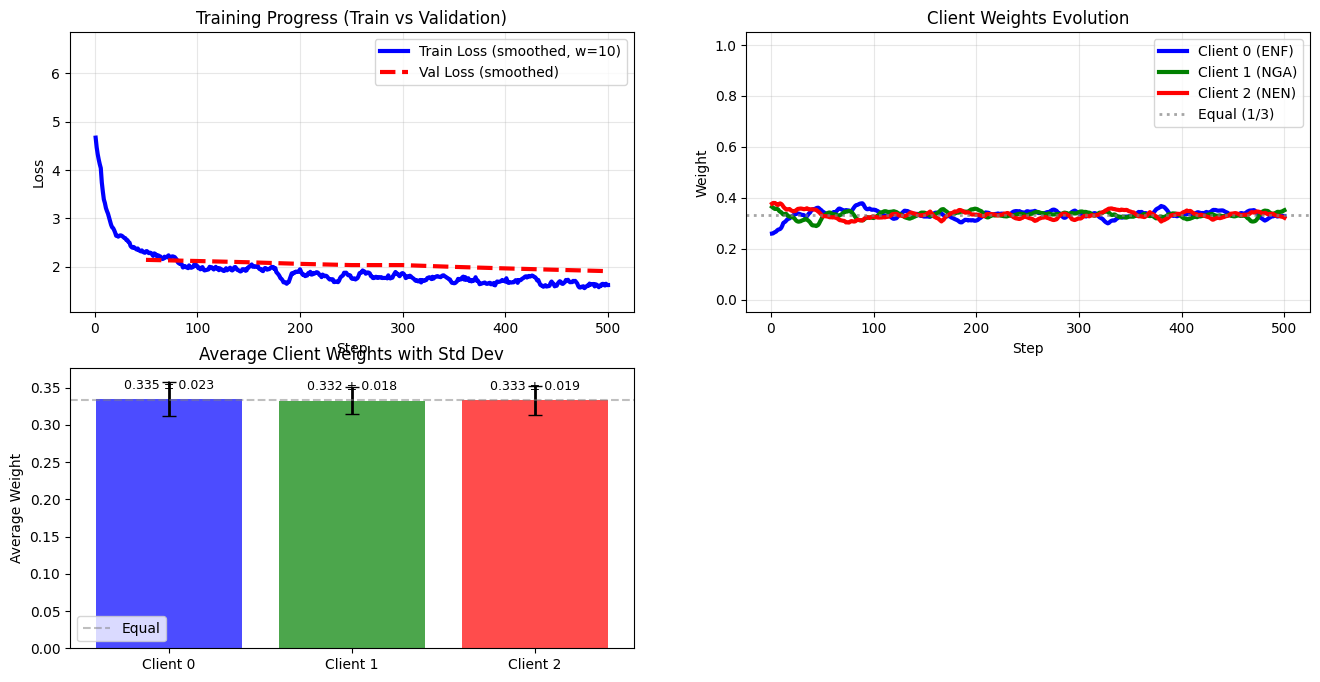

# Неродственный язык?

In [142]:
@dataclass
class Config:
    # основные параметры
    seed: int = 42
    epochs: int = 3
    max_steps: int = 500
    batch_size: int = 2
    lr: float = 3e-5

    # модель (не та, что в оригинальной статье -- но зато помещается в Колаб)
    model_type: str = "MarianMT"
    model_checkpoint: str = "Helsinki-NLP/opus-mt-en-ru"

    # данные
    max_seq_len: int = 32

    # federated learning
    fl: bool = True
    npeers: int = 4
    mdlr_: float = 0.1
    mdniters_: int = 2
    fl_beta_1: float = 0.9

    # сохранение
    save_every: int = 100
    save_strategy: str = "steps"
    saving_path: str = "/content/drive/MyDrive/meritopt_checkpoints"

    device: str = field(default_factory=lambda: "cuda" if torch.cuda.is_available() else "cpu")

    def __post_init__(self):
        import os
        os.makedirs(self.saving_path, exist_ok=True)

In [147]:
def load_my_dataset():
    """Загружаем и балансируем данные для 4 клиентов"""
    all_data = []

    # целевой размер для каждого клиента
    TARGET_SIZE = 10000

    try:
        # уральские языки
        print("Загрузка датасета katykool/samoyed.ic...")
        try:
            dataset1 = load_dataset("katykool/samoyed.ic")
        except Exception as e:
            print(f"Ошибка загрузки katykool/samoyed.ic: {e}")
            # локально, если есть
            try:
                dataset1 = load_dataset("samoyedic/samoyed.ic")
            except:
                print("Не удалось загрузить основной датасет")
                dataset1 = None

        if dataset1:
            if 'train' in dataset1:
                data1 = dataset1['train']
            else:
                data1 = dataset1

            # группируем по языкам
            data_by_lang = defaultdict(list)
            skipped = 0

            for item in data1:
                try:
                    original = item.get('original', '')
                    russian = item.get('russian_translation', '')
                    lang = item.get('lang', '')

                    if (original and russian and lang and
                        isinstance(original, str) and
                        isinstance(russian, str) and
                        isinstance(lang, str) and
                        len(original.strip()) > 0 and
                        len(russian.strip()) > 0):

                        data_by_lang[lang.strip().lower()].append({
                            'original': original.strip(),
                            'russian_translation': russian.strip(),
                            'lang': lang.strip().lower()
                        })
                    else:
                        skipped += 1

                except Exception as e:
                    skipped += 1

            # отбираем нужные языки и ограничиваем размер
            target_languages = ['enf', 'nga', 'nen']
            for lang in target_languages:
                if lang in data_by_lang:
                    lang_data = data_by_lang[lang]
                    random.shuffle(lang_data)
                    # только TARGET_SIZE примеров
                    lang_data = lang_data[:min(TARGET_SIZE, len(lang_data))]
                    all_data.extend(lang_data)
                    print(f"  {lang.upper()}: взято {len(lang_data)} примеров")
                else:
                    print(f"  Предупреждение: язык {lang} не найден")

        else:
            # Если не удалось загрузить, создадим синтетические данные для уральских языков
            print("ошибка")
            # target_languages = ['enf', 'nga', 'nen']
            # for lang in target_languages:
            #     lang_data = []
            #     for i in range(TARGET_SIZE):
            #         lang_data.append({
            #             'original': f"Пример на языке {lang.upper()} {i}",
            #             'russian_translation': f"Пример на русском {i}",
            #             'lang': lang
            #         })
            #     all_data.extend(lang_data)
            #     print(f"  {lang.upper()}: создано {TARGET_SIZE} синтетических примеров")

        # португальский
        try:
            dataset2 = load_dataset("open_subtitles", lang1="pt", lang2="ru")

            if 'train' in dataset2:
                data2 = dataset2['train']
                if len(data2) > TARGET_SIZE:
                    indices = list(range(len(data2)))
                    random.shuffle(indices)
                    data2 = data2.select(indices[:TARGET_SIZE])
            else:
                data2 = dataset2

            # обработка португальского датасета
            pt_data = []
            skipped_pt = 0

            for item in data2:
                try:
                    if 'translation' in item:
                        original = item['translation'].get('pt', '')
                        russian = item['translation'].get('ru', '')
                    else:
                        original = item.get('pt', item.get('source', ''))
                        russian = item.get('ru', item.get('target', ''))

                    if (original and russian and
                        isinstance(original, str) and
                        isinstance(russian, str) and
                        len(original.strip()) > 0 and
                        len(russian.strip()) > 0):

                        pt_data.append({
                            'original': original.strip(),
                            'russian_translation': russian.strip(),
                            'lang': 'pt'
                        })
                    else:
                        skipped_pt += 1

                except Exception as e:
                    skipped_pt += 1

            pt_data = pt_data[:min(TARGET_SIZE, len(pt_data))]
            all_data.extend(pt_data)
            print(f"  PT: добавлено {len(pt_data)} примеров")

        except Exception as e:
            print(f"Ошибка загрузки open_subtitles: {e}")


    except Exception as e:
        print(f"Критическая ошибка загрузки датасетов: {e}")

    # Статистика по языкам
    lang_counts = {}
    for item in all_data:
        lang = item['lang']
        lang_counts[lang] = lang_counts.get(lang, 0) + 1

    for lang, count in sorted(lang_counts.items()):
        print(f"  - {lang.upper()}: {count} примеров")

    print(f"\nВсего загружено {len(all_data)} примеров")

    print("\nпримеры данных:")
    for lang in ['enf', 'nga', 'nen', 'pt']:
        lang_examples = [d for d in all_data if d['lang'] == lang]
        if lang_examples:
            example = lang_examples[0]
            print(f"  {lang.upper()}: '{example['original'][:50]}...' → '{example['russian_translation'][:50]}...'")

    return all_data


def create_language_clients(config, tokenizer):
    """
    Создает сбалансированных клиентов по языкам
    """
    all_data = load_my_dataset()

    if not all_data:
        print("Нет данных! Создаем пустые клиенты...")
        return {}, None, {}

    # группируем данные по языкам
    data_by_language = defaultdict(list)
    for item in all_data:
        lang = item.get('lang', 'unknown')
        data_by_language[lang].append(item)

    # определяем языки для 4 клиентов
    target_languages = ['enf', 'nga', 'nen', 'pt']

    available_languages = []
    for lang in target_languages:
        if lang in data_by_language and len(data_by_language[lang]) > 0:
            available_languages.append(lang)
        else:
            print(f"Предупреждение: язык {lang} не найден или пуст!")
            if lang in data_by_language:
                print(f"  Данных для {lang}: {len(data_by_language[lang])}")

    if not available_languages:
        print("Нет доступных языков!")
        return {}, None, {}

    print(f"\nСоздание {len(available_languages)} сбалансированных клиентов:")

    # создаем DataLoader для каждого клиента
    train_loaders = {}
    val_loaders = {}
    test_loaders = {}

    for i, lang in enumerate(available_languages):
        lang_data = data_by_language[lang]

        # if len(lang_data) == 0:
        #     print(f"  Клиент {i} ({lang.upper()}): НЕТ ДАННЫХ!")
        #     continue

        random.shuffle(lang_data)

        # разделяем на train/val/test (70/20/10)
        n_total = len(lang_data)
        n_train = int(n_total * 0.7)
        n_val = int(n_total * 0.2)

        train_data = lang_data[:n_train]
        val_data = lang_data[n_train:n_train + n_val]
        test_data = lang_data[n_train + n_val:]

        print(f"  Клиент {i} ({lang.upper()}):")
        print(f"    Всего: {n_total} примеров")
        print(f"    Train: {len(train_data)} примеров")
        print(f"    Val: {len(val_data)} примеров")
        print(f"    Test: {len(test_data)} примеров")

        # if len(train_data) > 0:
        #     print(f"    Пример: '{train_data[0]['original'][:50]}...' → '{train_data[0]['russian_translation'][:50]}...'")

        # создаем датасеты
        train_dataset = TranslationDataset(train_data, split="train")
        val_dataset = TranslationDataset(val_data, split="val")
        test_dataset = TranslationDataset(test_data, split="test")

        # создаем DataLoaderы
        train_loader = DataLoader(
            train_dataset,
            batch_size=config.batch_size,
            shuffle=True,
            collate_fn=lambda x: x,
            num_workers=0
        )

        val_loader = DataLoader(
            val_dataset,
            batch_size=config.batch_size,
            shuffle=False,
            collate_fn=lambda x: x,
            num_workers=0
        )

        test_loader = DataLoader(
            test_dataset,
            batch_size=config.batch_size,
            shuffle=False,
            collate_fn=lambda x: x,
            num_workers=0
        )

        train_loaders[i] = train_loader
        val_loaders[i] = val_loader
        test_loaders[i] = test_loader

    # общий валидационный загрузчик из всех языков
    all_val_data = []
    for lang in available_languages:
        if lang in data_by_language and data_by_language[lang]:
            lang_data = data_by_language[lang]
            # по 2 примера из каждого языка
            sample_size = min(2, len(lang_data))
            if sample_size > 0:
                all_val_data.extend(random.sample(lang_data, sample_size))

    if all_val_data:
        combined_val_dataset = TranslationDataset(all_val_data, split="val")
        combined_val_loader = DataLoader(
            combined_val_dataset,
            batch_size=config.batch_size,
            shuffle=False,
            collate_fn=lambda x: x,
            num_workers=0
        )
    else:
        combined_val_loader = None

    # проверяем, что есть хотя бы один клиент
    if len(train_loaders) == 0:
        print("Не создано ни одного клиента!")
        return {}, None, {}

    return train_loaders, combined_val_loader, test_loaders

In [148]:
def visualize_results(logger, smooth_window=10):
    """Визуализация для 4 клиентов"""
    try:
        import matplotlib.pyplot as plt
        import numpy as np

        def smooth_curve_centered(data, window_size=5):
            if len(data) < window_size or window_size < 2:
                return data.copy()

            smoothed = np.zeros_like(data, dtype=float)
            half = window_size // 2

            for i in range(len(data)):
                start = max(0, i - half)
                end = min(len(data), i + half + 1)
                smoothed[i] = np.mean(data[start:end])

            return smoothed

        # данные
        train_losses = []
        val_losses = []
        client_weights = {i: [] for i in range(4)}  # 4 клиента

        train_steps = []
        val_steps = []
        weight_steps = {i: [] for i in range(4)}

        for metric in logger.metrics_history:
            if metric['name'] == 'loss' and metric['mode'] == 'train':
                train_losses.append(metric['value'])
                train_steps.append(metric['step'])
            elif metric['name'] == 'val_loss':
                val_losses.append(metric['value'])
                val_steps.append(metric['step'])
            elif 'weight_client' in metric['name']:
                try:
                    client_id = int(metric['name'].split('_')[-1])
                    if client_id < 4:
                        client_weights[client_id].append(metric['value'])
                        weight_steps[client_id].append(metric['step'])
                except:
                    pass

        # loss
        plt.figure(figsize=(16, 10))

        if train_losses:
            plt.subplot(2, 3, 1)

            # plt.scatter(train_steps, train_losses, alpha=0.3, s=15, color='blue',
            #            label=f'Raw Train Loss ({len(train_losses)} points)')

            if len(train_losses) >= smooth_window:
                smoothed_train = smooth_curve_centered(train_losses, smooth_window)
                plt.plot(train_steps, smoothed_train, 'b-', linewidth=3,
                        label=f'Train Loss (smoothed, w={smooth_window})')
            else:
                plt.plot(train_steps, train_losses, 'b-', linewidth=2, label='Train Loss')

            if val_losses and len(val_losses) > 0:
                # plt.scatter(val_steps, val_losses, alpha=0.7, s=80, color='red',
                          #  marker='s', label=f'Raw Val Loss ({len(val_losses)} points)')

                if len(val_losses) >= max(3, smooth_window//2):
                    smoothed_val = smooth_curve_centered(val_losses, min(smooth_window, len(val_losses)))
                    plt.plot(val_steps, smoothed_val, 'r--', linewidth=3,
                            label=f'Val Loss (smoothed)', markersize=8)
                else:
                    plt.plot(val_steps, val_losses, 'r--', linewidth=2,
                            label='Val Loss', markersize=8)

            plt.xlabel('Step')
            plt.ylabel('Loss')
            plt.title('Training Progress (Train vs Validation)')
            plt.legend(loc='best')
            plt.grid(True, alpha=0.3)

            if train_losses:
                y_max = max(max(train_losses), max(val_losses) if val_losses else 0) * 1.1
                y_min = min(min(train_losses), min(val_losses) if val_losses else 0) * 0.9
                plt.ylim(y_min, y_max)

        # график весов клиентов
        plt.subplot(2, 3, 2)
        has_weights = False

        colors = ['blue', 'green', 'red', 'purple']
        labels = ['Client 0 (ENF)', 'Client 1 (NGA)', 'Client 2 (NEN)', 'Client 3 (PT)']

        for client_id in range(4):
            weights = client_weights.get(client_id, [])
            steps = weight_steps.get(client_id, [])

            if weights and len(weights) > 0:
                has_weights = True

                # plt.scatter(steps, weights, alpha=0.3, s=20, color=colors[client_id])

                if len(weights) >= smooth_window:
                    smoothed_weights = smooth_curve_centered(weights, smooth_window)
                    plt.plot(steps, smoothed_weights, color=colors[client_id],
                            linewidth=3, label=labels[client_id])
                else:
                    plt.plot(steps, weights, color=colors[client_id],
                            linewidth=2, label=labels[client_id])

        if has_weights:
            plt.xlabel('Step')
            plt.ylabel('Weight')
            plt.title('Client Weights Evolution (4 clients)')
            plt.legend(loc='best')
            plt.grid(True, alpha=0.3)

            # линия равных весов (1/4 для 4 клиентов)
            plt.axhline(y=0.25, color='gray', linestyle=':', alpha=0.7,
                       linewidth=2, label='Equal (0.25)')
            plt.legend()
            plt.ylim(-0.05, 1.05)

        # гистограмма средних весов
        plt.subplot(2, 3, 3)

        avg_weights = []
        std_weights = []
        client_labels = []

        for client_id in range(4):
            weights = client_weights.get(client_id, [])
            if weights:
                avg_weights.append(np.mean(weights))
                std_weights.append(np.std(weights) if len(weights) > 1 else 0)
                client_labels.append(f'Client {client_id}')

        if avg_weights:
            x_pos = np.arange(len(avg_weights))
            bars = plt.bar(x_pos, avg_weights, yerr=std_weights,
                          color=colors[:len(avg_weights)], alpha=0.7,
                          capsize=5, error_kw={'elinewidth': 2})

            plt.axhline(y=0.25, color='gray', linestyle='--', alpha=0.5, label='Equal')

            for i, (bar, avg, std) in enumerate(zip(bars, avg_weights, std_weights)):
                height = bar.get_height()
                plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                        f'{avg:.3f} ± {std:.3f}', ha='center', va='bottom', fontsize=9)

            plt.xticks(x_pos, client_labels)
            plt.ylabel('Average Weight')
            plt.title('Average Client Weights (4 clients)')
            plt.legend()


        plt.tight_layout()
        plt.show()


    except Exception as e:
        print(f"Не удалось построить графики: {e}")
        import traceback
        traceback.print_exc()

In [149]:
def main_simple():
    config = Config()
    config.npeers = 4
    config.epochs = 1
    config.max_steps = 500
    config.batch_size = 2
    config.val_every = 50

    logger = SimpleLogger()

    tokenizer = AutoTokenizer.from_pretrained(config.model_checkpoint)
    model = AutoModelForSeq2SeqLM.from_pretrained(config.model_checkpoint)
    model = model.to(config.device)

    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    train_loaders, val_loader, test_loaders = create_language_clients(config, tokenizer)

    optimizer = MeritFedAdamFixed(model.parameters(), config)


    for epoch in range(config.epochs):
        print(f"\nEpoch {epoch+1}/{config.epochs}")

        train_loss = train_epoch_fl_simple_fixed(
            model=model,
            tokenizer=tokenizer,
            optimizer=optimizer,
            train_loaders=train_loaders,
            val_loader=val_loader,
            logger=logger,
            config=config,
            epoch=epoch,
            val_every=config.val_every
        )

        # финальная валидация
        model.eval()
        val_loss, val_batches = validate_simple(model, tokenizer, val_loader, logger, config)
        model.train()

        print(f"\nEpoch {epoch+1} completed:")
        print(f"   Train Loss = {train_loss:.4f}")
        print(f"   Val Loss = {val_loss:.4f} ({val_batches} batches)")

        save_model_simple(model, tokenizer, config, epoch=epoch+1)

        if logger.get_step() >= config.max_steps:
            break


    visualize_results(logger)
    return model, tokenizer, logger

Загрузка датасета katykool/samoyed.ic...
Загружено 97434 примеров из katykool/samoyed.ic
  ENF: взято 10000 примеров
  NGA: взято 10000 примеров
  NEN: взято 10000 примеров
Всего уральских примеров: 30000

Загрузка датасета open_subtitles (pt-ru)...
Ошибка загрузки open_subtitles: Dataset scripts are no longer supported, but found open_subtitles.py
Создаем синтетические данные для португальского...
  PT: создано 10000 синтетических примеров

Сбалансированная статистика по языкам (целевой размер: 10000):
  - ENF: 10000 примеров
  - NEN: 10000 примеров
  - NGA: 10000 примеров
  - PT: 10000 примеров

Всего загружено 40000 примеров

Примеры данных:
  ENF: 'Anʼi čikoxone aʔ...' → 'Опять там они....'
  NGA: 'MiiɁi͡a tətuŋuruɁ...' → 'Сюда приведите....'
  NEN: 'Ee katatu tatʼa ŋamčoʔ wʼiwʼintoɬʼa maɬama Ŋajɬʼa ...' → 'Бабушка сидит, раздумывая, говорит: «Что тут плохо...'
  PT: 'Exemplo em português 0...' → 'Пример на русском 0...'

Создание 4 сбалансированных клиентов:
  Клиент 0 (ENF):
    

FL Epoch 1:   0%|          | 0/3500 [00:00<?, ?it/s]


[Processing] Client 0, batch 0
  Loss for client 0: 6.3562
  Collected 253 gradients

[Processing] Client 1, batch 0
  Loss for client 1: 6.1468
  Collected 253 gradients

[Processing] Client 2, batch 0
  Loss for client 2: 7.1694
  Collected 253 gradients

[Processing] Client 3, batch 0
  Loss for client 3: 6.7337
  Collected 253 gradients

[register_all_gradients] Step 1
  Client 0: total grad norm = 298.394402 (253 params)
  Client 1: total grad norm = 294.938001 (253 params)
  Client 2: total grad norm = 369.340984 (253 params)
  Client 3: total grad norm = 381.729126 (253 params)

=== Optimizer Step 1 ===

=== Updating Client Weights (Step 1) ===
Gradient norms: [20.862607955932617, 20.82631492614746, 28.84539031982422, 26.908348083496094]
Target weights: [0.285688191652298, 0.2861860394477844, 0.20662575960159302, 0.22150003910064697]
Updated weights: [0.26070648431777954, 0.2608558237552643, 0.23698773980140686, 0.24145002663135529]

[Processing] Client 0, batch 1
  Loss for cl

/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:3918: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 512, 'num_beams': 4, 'bad_words_ids': [[62517]]}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


Выходные данные были обрезаны до нескольких последних строк (5000).
[Processing] Client 0, batch 334
  Loss for client 0: 2.0615
  Collected 253 gradients

[Processing] Client 1, batch 334
  Loss for client 1: 1.9625
  Collected 253 gradients

[Processing] Client 2, batch 334
  Loss for client 2: 2.3843
  Collected 253 gradients

[Processing] Client 3, batch 334
  Loss for client 3: 0.0005
  Collected 253 gradients

[register_all_gradients] Step 335
  Client 0: total grad norm = 97.129739 (253 params)
  Client 1: total grad norm = 76.983929 (253 params)
  Client 2: total grad norm = 83.175102 (253 params)
  Client 3: total grad norm = 0.171415 (253 params)

=== Optimizer Step 335 ===

=== Updating Client Weights (Step 335) ===
Gradient norms: [10.212879180908203, 8.8919095993042, 8.625021934509277, 0.016005506739020348]
Target weights: [0.0015590466791763902, 0.0017906564753502607, 0.0018460655119270086, 0.9948042631149292]
Updated weights: [0.01663251779973507, 0.017688851803541183, 0

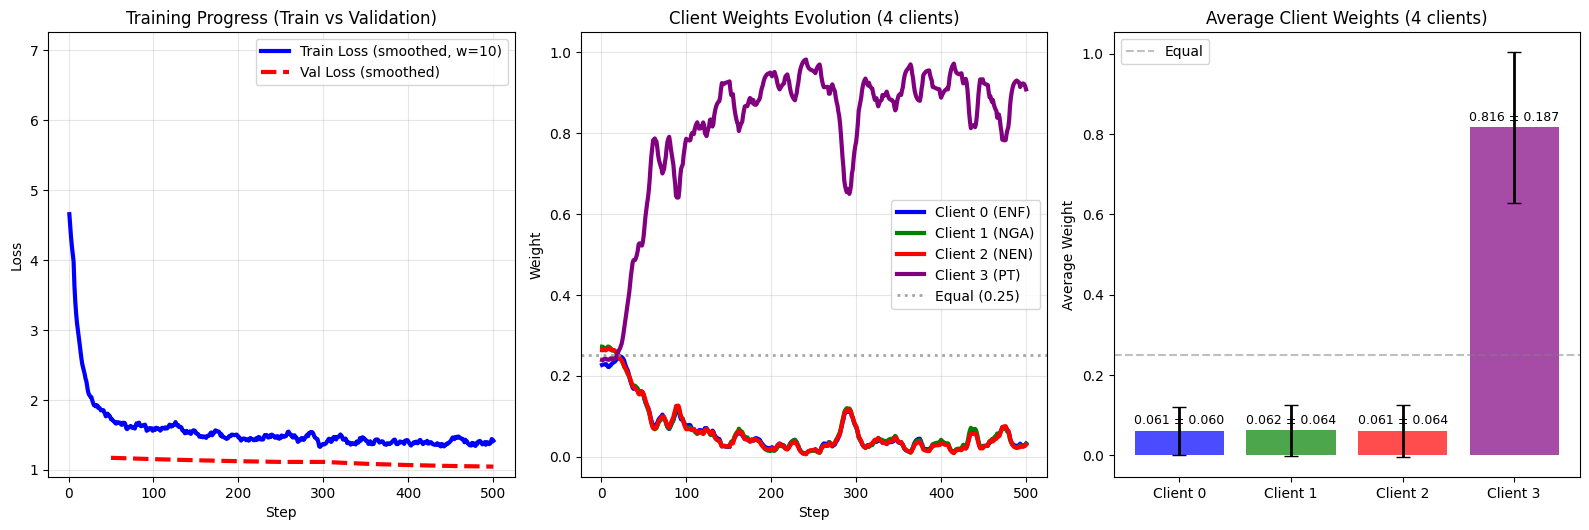

In [150]:
torch.cuda.empty_cache()
try:
    model, tokenizer, logger = main_simple()
except Exception as e:
    print(f"Ошибка: {e}")
    import traceback
    traceback.print_exc()

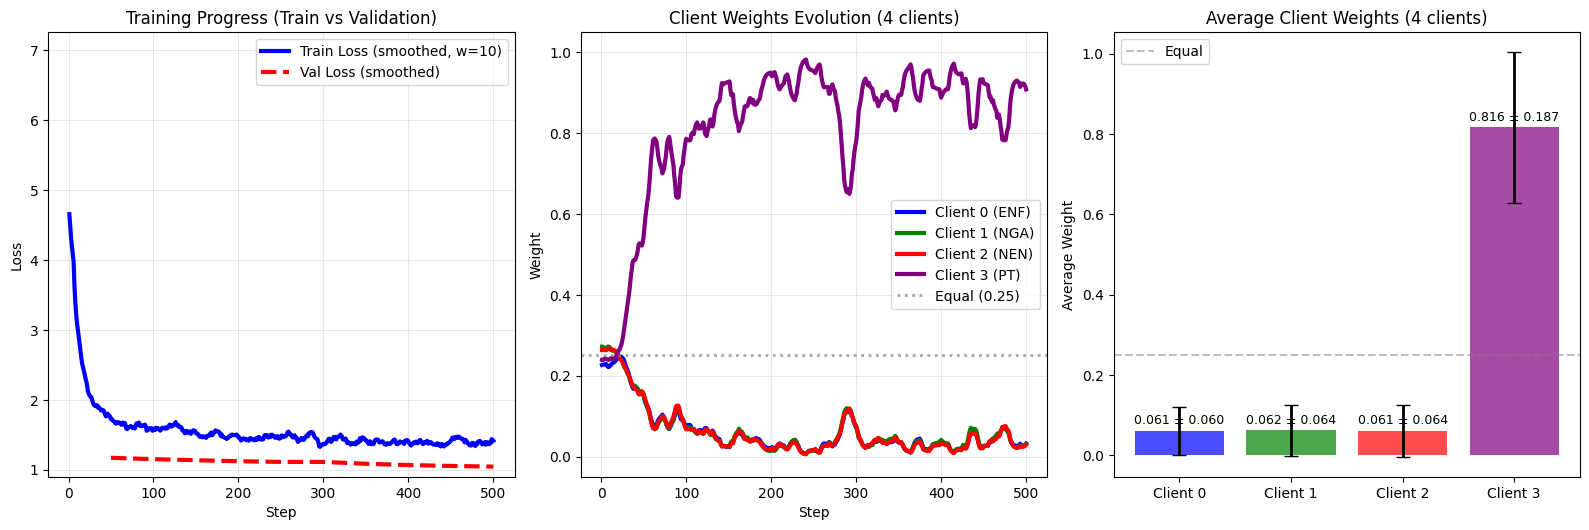

Клиенты:
* `ENF` -- **энецкие** -- 51777 примеров -- *синим* цветом
* `NGA` -- **нганасанский** -- 34609 примеров -- *рыжим* цветом
* `NEN` -- **ненецкие** -- 10222 примеров -- *зеленым* цветом